APS360: GeoScout

In [ ]:
import torch
torch.manual_seed(42)

In [ ]:
# Libraries needed
!pip install s2cell
# !pip install geopy
# !pip install pycountry_convert
# !pip install reverse_geocoder
!pip install scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# run this if you want the files to be stored locally here (much faster, but will get deleted after end of session)
!unzip -q -o /content/drive/MyDrive/APS360/dataset.zip -d /content

unzip:  cannot find or open /content/drive/MyDrive/APS360/dataset.zip, /content/drive/MyDrive/APS360/dataset.zip.zip or /content/drive/MyDrive/APS360/dataset.zip.ZIP.


In [ ]:
# run this if you want the files to be stored to your cloud drive (much slower but you won't have to run it again)
!unzip -q -o /content/drive/MyDrive/APS360/dataset.zip -d /content/drive/MyDrive/APS360

unzip:  cannot find or open /content/drive/MyDrive/APS360/dataset.zip, /content/drive/MyDrive/APS360/dataset.zip.zip or /content/drive/MyDrive/APS360/dataset.zip.ZIP.


In [ ]:
!unzip -q -o /content/drive/MyDrive/APS360/GeoScout_Dataset.zip -d /content/drive/MyDrive/APS360

In [ ]:
# helper functions
def find_idx_from_image(image_id, data_dict):
    for data in range(len(data_dict)):
        # print(data_dict[data]['image'] + " | " + f"{image_id}.png")
        if data_dict[data]['image'] == f"{image_id}.png": return data
    return -1

In [ ]:
import pycountry_convert as pc
def country_to_continent(country_alpha2):
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [ ]:
import csv
import s2cell
from PIL import Image
import matplotlib.pyplot as plt
import reverse_geocoder as rg

cloud_root_10k = '/content/drive/MyDrive/APS360/dataset/'
local_root_10k = '/content/dataset/'
cloud_root_25k = '/content/drive/MyDrive/APS360/Streetview_Image_Dataset/'
local_root_25k = '/content/Streetview_Image_Dataset/'
dataset_root = cloud_root_25k
coord_file_10k = 'coords.csv'
coord_file_25k = 'coordinates.csv'
coord_file = coord_file_25k

unique = set()
unique_cell_ids = set()
data_dicts = []
continents = {}
min_id, max_id = float('inf'), 0

with open(dataset_root + coord_file, mode='r', newline='') as file:
    csv_reader = csv.reader(file);
    n = 0
    for line in enumerate(csv_reader):
        id, coord_pair = (line[0], (line[1][0], line[1][1])); # enumerated data format is id, (lat, lon)
        if id == 0: continue # first line in csv is lat, lon
        if coord_pair not in unique:
          unique.add(coord_pair)
          cell_id = s2cell.lat_lon_to_cell_id(float(coord_pair[0]), float(coord_pair[1]), 3) # level 3, larger number = smaller cells
          min_id = min(min_id, cell_id)
          max_id = max(max_id, cell_id)
          unique_cell_ids.add(cell_id)

          # country = rg.search((float(coord_pair[0]), float(coord_pair[1])))[0]['cc']
          # continent = country_to_continent(country)
          # if continent not in continents: continents[continent] = 1
          # else: continents[continent] += 1

          data_point = {"image": f"{id - 1}.png", "label": cell_id, "coords": coord_pair}
          data_dicts.append(data_point)
          # n+=1
          # if n % 100 == 0: print(f"Processed {n} images")

print(f"Unique locations: {len(data_dicts)}")
print(f"Unique cell ids: {len(unique_cell_ids)}")
print(f"Sample data point: {data_dicts[find_idx_from_image(1976, data_dicts)]}")
# print(continents)
# plt.bar(range(len(continents)), list(continents.values()), tick_label=list(continents.keys()))
# plt.show()

Unique locations: 24702
Unique cell ids: 155
Sample data point: {'image': '1976.png', 'label': 6755399441055744000, 'coords': ('49.78106981', '106.9295981')}


In [ ]:
def find_closest_s2_id(computed_id, valid_ids):
    # Convert computed_id back to valid ID if necessary
    computed_id = int(computed_id)  # Assuming you have a valid integer ID
    # Calculate the closest valid S2 cell ID
    closest_id = None
    min_distance = float('inf')

    for valid_id in valid_ids:
        distance = abs(valid_id - computed_id)  # Integer difference
        if distance < min_distance:
            min_distance = distance
            closest_id = valid_id

    return closest_id

In [ ]:
# Test code for geopy reverse location lookup
# Trial 1: Most Accurate True Coords reverse look up
import geopy
from geopy.geocoders import Nominatim

geolocater = Nominatim(user_agent="GeoScout_360") # can get rate limited (swap id if need run more)
id = find_idx_from_image(1234, data_dicts)

lat_lon_geopy = str(data_dicts[id]['coords'][0]) + ", " + str(data_dicts[id]['coords'][1])
print(lat_lon_geopy)
location = geolocater.reverse(lat_lon_geopy, exactly_one=True, language="en-US")
if location: print(location.address)

# Trial 2: Theoretically less accurate S2 coords reverse look up
temp = s2cell.cell_id_to_lat_lon(data_dicts[id]['label'])
# temp = s2cell.cell_id_to_lat_lon(9925933578724573184)

lat_lon_geopy = str(temp[0]) + ", " + str(temp[1])
print(lat_lon_geopy)
location = geolocater.reverse(lat_lon_geopy, exactly_one=True, language="en-US")
if location: print(location.address)

58.24650146680182, 92.47238860568629
2А, улица Горького, Северный микрорайон, Школьный, Lesosibirsk, городской округ Лесосибирск, Krasnoyarsk Krai, Siberian Federal District, 662549, Russia
61.01370970683677, 99.19665589162891
Evenkiysky Rayon, Krasnoyarsk Krai, Siberian Federal District, Russia


In [ ]:
from torch.utils.data import Dataset
class GeoScoutDataset(Dataset):
    def __init__(self, data_dicts, transform=None, target_transform=None):
        self.data_dicts = data_dicts
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data_dicts)

    def __getitem__(self, idx):
        img_path = dataset_root + self.data_dicts[idx]["image"]
        label = self.data_dicts[idx]["label"]

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [ ]:
# Transform helpers

import torch
from torchvision import transforms
from PIL import Image
from torchvision.transforms import InterpolationMode

# Transform dataset without caching
transform_Comp_Train = transforms.Compose([
  transforms.RandomHorizontalFlip(), # flips image with default probability of 0.5
  transforms.RandomRotation(10, expand=True), # always rotates from 0 to degrees value set
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

transform_Comp_Basic = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

def transform_label(label):
  return torch.tensor(label, dtype=torch.float)

def transform_dataset(appended_dicts, transform_type):
  transformed_data = GeoScoutDataset(
      data_dicts=appended_dicts,
      transform=transform_type,
      target_transform=transform_label
  )
  return transformed_data

In [ ]:
# Put data split here
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import math
import random

test_length = len(unique)
batch_size = 1
random.seed(42)
random.shuffle(data_dicts)

def create_datasets(train_split,test_length):
  # function runs through entire database of images and applies transforms, before saving all data as pre-processing
  train_dataset = transform_dataset(data_dicts[:train_split], transform_Comp_Train)
  basic_dataset = transform_dataset(data_dicts[train_split:test_length], transform_Comp_Basic)
  torch.save(train_dataset, "/content/drive/MyDrive/APS360/train_dataset_manual_25k.pt")
  torch.save(basic_dataset, "/content/drive/MyDrive/APS360/basic_dataset_manual_25k.pt")

def unzip_datasets():
  !unzip -q -o /content/drive/MyDrive/APS360/Datasets/datasets.zip -d /content # will unzip datasets to local storage (will be saved after leaving session)

def get_data_loader(batch_size, test_length):
  split = list(map(lambda num: math.floor(test_length * num), [0.8, 0.1]))

  create_datasets(split[0], test_length) # call this function only if you want to make a new dataset which will be saved
  # unzip_datasets()
  train_dataset = torch.load("/content/drive/MyDrive/APS360/train_dataset_manual_25k.pt")
  basic_dataset = torch.load("/content/drive/MyDrive/APS360/basic_dataset_manual_25k.pt")

  train_sampler = SubsetRandomSampler(list(range(0, split[0])))
  # can we try with basic dataset first, or smaller angle of rotation (and no flipping cuz we want to preserve driving direction/direction of sun and shadows)
  train_loader = DataLoader(
      train_dataset, batch_size=batch_size, num_workers=2, sampler=train_sampler, drop_last=True) # note that google doesn't like num_workers higher than 2

  val_sampler = SubsetRandomSampler(list(range(split[1])))
  val_loader = DataLoader(
      basic_dataset, batch_size=batch_size, num_workers=2, sampler=val_sampler, drop_last=True)

  test_sampler = SubsetRandomSampler(list(range(split[1], test_length - split[0])))
  test_loader = DataLoader(
      basic_dataset, batch_size=batch_size, num_workers=2, sampler=test_sampler, drop_last=True)

  print(f"Train size: {len(train_sampler)}")
  print(f"Val size: {len(val_sampler)}")
  print(f"Test size: {len(test_sampler)}")
  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data_loader(batch_size, test_length)

NameError: name 'unique' is not defined

In [ ]:
from torchvision import datasets
from torch.utils.data import Subset
import os

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/APS360/GeoScout_Dataset/')
class_idx_to_name = {v: k for k, v in dataset.class_to_idx.items()}
print(class_idx_to_name)
def get_data_loader_2(batch_size=32, test_length=1000):

  train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

  train_data.dataset.transform = transform_Comp_Train
  val_data.dataset.transform = transform_Comp_Basic
  test_data.dataset.transform = transform_Comp_Basic

  subset_lengths = [int(x * test_length) for x in [0.8, 0.1, 0.1]]

  train_loader = torch.utils.data.DataLoader(Subset(train_data, range(subset_lengths[0])), batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(Subset(val_data, range(subset_lengths[1])), batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(Subset(test_data, range(subset_lengths[2])), batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

{0: '10250192751895248896', 1: '10610480722084888576', 2: '1062849512059437056', 3: '10682538316122816512', 4: '10718567113141780480', 5: '10790624707179708416', 6: '10826653504198672384', 7: '1170935903116328960', 8: '1495195076287004672', 9: '1531223873305968640', 10: '2215771016666284032', 11: '3152519739159347200', 12: '3332663724254167040', 13: '3548836506367950848', 14: '3584865303386914816', 15: '3837066882519662592', 16: '4233383649728266240', 17: '4305441243766194176', 18: '4701758010974797824', 19: '5062045981164437504', 20: '5098074778183401472', 21: '5206161169240293376', 22: '522417556774977536', 23: '6935543426150563840', 24: '7656119366529843200', 25: '7692148163548807168', 26: '7728176960567771136', 27: '7764205757586735104', 28: '9277415232383221760', 29: '954763121002545152', 30: '9853875984686645248', 31: '9925933578724573184'}


BATCH: 0


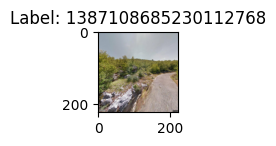

BATCH: 1


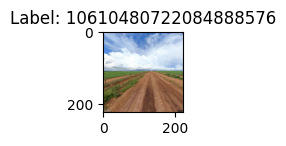

BATCH: 2


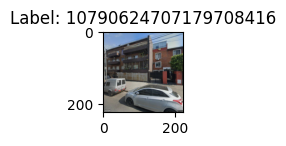

BATCH: 3


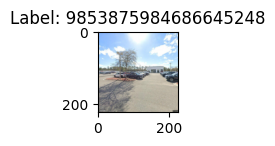

In [ ]:
import matplotlib.pyplot as plt

def visualize_some_data(data_loader): # something is weird with test_loader; can't access the batches that are stored in it / could possibly mean corrupt data in the pth file / wouldn't explain why val_loader is fine
  i = 0
  for batch_id, batch in enumerate(data_loader): # prints out the first images of 16 batches
    try:
      print(f"BATCH: {batch_id}")
    except IndexError:
      print(f"Error at {batch_id} | {str(IndexError)}")

    image, label = batch[0][0], batch[1][0]

    plt.subplot(4, 4, i+1)
    plt.title('Label: ' + class_idx_to_name[label.item()])
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

    i += 1
    if i > 5: break

# print(len(test_loader))
visualize_some_data(get_data_loader_2()[2])

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 31.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


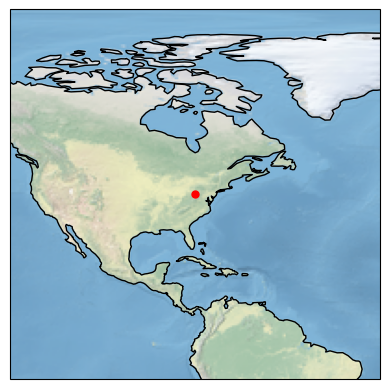

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Coordinate pair
def plot_lat_long(latitude, longitude, colour):

  zoom_margin = 50  # Degrees of margin for zooming
  extent = [longitude - zoom_margin, longitude + zoom_margin,
            latitude - zoom_margin, latitude + zoom_margin]

  fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
  ax.stock_img()
  ax.coastlines()

  ax.set_extent(extent, crs=ccrs.PlateCarree())
  ax.plot(longitude, latitude, marker='o', color=colour, markersize=5, transform=ccrs.PlateCarree())

  plt.show()

plot_lat_long(40, -80, 'red')

In [ ]:
# baseline model DRAFT
import torch.nn as nn
import torch.nn.functional as F
# baseline model DRAFT
import torch.nn as nn
import torch.nn.functional as F
class GeolocationCNN(nn.Module):
    def __init__(self):
        super(GeolocationCNN, self).__init__()
        self.name = "GeolocationCNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_imgs = 0
    correct = 0
    eval_net = net.eval()
    if torch.cuda.is_available():
        eval_net.cuda()
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        # Forward pass
        out = eval_net(inputs)
        loss = criterion(out, labels)
        total_loss += loss.item()

        prediction = out.max(1, keepdim=True)[1]
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
        total_imgs += inputs.shape[0]

    loss = float(total_loss) / (len(loader))
    error = (total_imgs - correct) / total_imgs
    return error, loss

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def generate_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in loader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cl = classification_report(all_preds, all_labels)
    print(cl)
    cm = confusion_matrix(all_labels, all_preds)
    # plt.figure(figsize=(100, 100))
    # # ConfusionMatrixDisplay(cm).plot()
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap='Blues')
    # plt.title('Confusion Matrix')
    # plt.show()

    fig, ax = plt.subplots(figsize=(15, 15))  # Create a figure and set the size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax)  # Use ax to ensure it uses the correct figure and axis
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
import torch.optim as optim
import torch.nn as nn
import time
import numpy as np

def train_baseline(net, batch_size=64, learning_rate=0.001, num_epochs=30, test_length=1000):
    torch.manual_seed(1000)

    if torch.cuda.is_available():
        net.cuda()

    train_loader, val_loader, test_loader = get_data_loader_2(batch_size, test_length)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            print(f"Batch: {i}")

            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

        train_err[epoch], train_loss[epoch] = evaluate(net, train_loader, criterion)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    plot_training_curve(model_path)
    generate_confusion_matrix(net, test_loader)


In [ ]:
model = GeolocationCNN()
train_baseline(model, batch_size=64, learning_rate=0.001, num_epochs=20, test_length=len(dataset))

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99
Batch: 100

KeyboardInterrupt: 

ResNet

Trial 1

In [ ]:
#transfer learning with ResNet-34
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
train_data = torch.load("./train_dataset_manual_10k.pt")#gives error
val_data = torch.load("./basic_dataset_manual_10k.pt")
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
class ResNet34(nn.Module):
    def __init__(self, output_dim=1):
        super(ResNet34, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, output_dim)

        # Freeze all layers except the last fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True  # Unfreeze the final layer

    def forward(self, x):
        return self.model(x)

# Set output dimension as needed
output_dim = 131  # Change based on S2 cells
resnet_model = ResNet34(output_dim=output_dim)

# Move model to GPU if available
if torch.cuda.is_available():
    resnet_model = resnet_model.cuda()
    print('We are using the GPU')

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # Replace if neededed
optimizer = optim.Adam(resnet_model.model.fc.parameters(), lr=0.001)


def train(num_epochs, model, criterion, optimizer, train_loader, val_loader, batch_size, learning_rate):
    # Arrays to store training and validation errors and losses
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # To keep track of iterations for plotting
    iters = []
    losses = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for batch_id, (data, gtl) in enumerate(train_loader):
            if torch.cuda.is_available():
                data = data.cuda()
                gtl = gtl.cuda()

            # Clear old gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Compute loss
            loss = criterion(output.squeeze(), gtl)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss for plotting
            losses.append(loss.item())
            iters.append(epoch * len(train_loader) + batch_id)

        # Evaluate on training and validation sets
        train_err[epoch], train_loss[epoch] = evaluate(model, train_loader, criterion)
        val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

        # Print metrics at the end of each epoch
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | " +
              f"Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        # Save model checkpoint for the current epoch
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        # Store accuracies for plotting (you might want to define how to calculate accuracy)
        train_acc.append(train_err[epoch])  # Replace with actual accuracy calculation if needed
        val_acc.append(val_err[epoch])  # Replace with actual accuracy calculation if needed

    # Plotting the loss curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Training Loss Curve")
    plt.plot(iters, losses, label="Train Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()

    # Plotting the accuracy curve
    plt.subplot(1, 2, 2)
    plt.title("Training and Validation Accuracy Curve")
    plt.plot(iters, train_acc, label="Train Accuracy")
    plt.plot(iters, val_acc, label="Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.show()

    print('Finished Training')
# Run Training
num_epochs = 10  # specify number of epochs
batch_size = 128
learning_rate = 0.001
train(num_epochs, resnet_model, criterion, optimizer, train_loader, val_loader, batch_size, learning_rate)

In [ ]:
# If the zip file is stored in Google Drive, first mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Unzip the file (replace 'GeoScout_Dataset.zip' with your actual zip file path)
!unzip /content/drive/MyDrive/GeoScout_Dataset.zip -d /content/drive/MyDrive/APS360/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/366.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/3760.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/3794.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/380.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/4104.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/4159.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/4203.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/4314.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/4330.png  
  inflating: /content/drive/MyDrive/APS360/GeoScout_Dataset/4665729213955833856/4350.png  
  inflating: /content/drive/MyDrive/APS36

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/APS360/GeoScout_Dataset/'))

['9853875984686645248', '9637703202572861440', '7692148163548807168', '7728176960567771136', '7764205757586735104', '954763121002545152', '9817847187667681280', '9925933578724573184', '9277415232383221760', '10250192751895248896', '10610480722084888576', '10682538316122816512', '10718567113141780480', '10790624707179708416', '10826653504198672384', '1170935903116328960', '1351079888211148800', '1387108685230112768', '1495195076287004672', '1531223873305968640', '2215771016666284032', '3152519739159347200', '3332663724254167040', '3548836506367950848', '3584865303386914816', '3837066882519662592', '4233383649728266240', '4665729213955833856', '4701758010974797824', '5062045981164437504', '5098074778183401472', '5134103575202365440', '5170132372221329408', '5206161169240293376', '522417556774977536', '6935543426150563840', '7656119366529843200']


In [ ]:
#Potential loss functions :
# dataset has imbalanced classes, consider using a weighted loss (e.g., CrossEntropyLoss(weight=class_weights)). Use torch.utils.data.WeightedRandomSampler to balance the training dataset.
#MSE with Coordinate Normalization: Normalize latitude and longitude to ensure uniform scaling and then use MSE.
#Vincenty Loss: A more accurate geodesic distance formula than Haversine, especially for longer distances. It accounts for the ellipsoidal shape of the Earth rather than treating it as a perfect sphere. Implementation: geopy to compute Vincenty distances, then incorporate them into loss function.



In [ ]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import random
random.seed(42)
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
import sys
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
# many overlap, but for convenience

In [ ]:
from torchvision import datasets
from torch.utils.data import Subset, ConcatDataset
import os
from torchvision import transforms
from PIL import Image
from torchvision.transforms import InterpolationMode
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/APS360/GeoScout_Dataset/')
class_idx_to_name = {v: k for k, v in dataset.class_to_idx.items()}
print(class_idx_to_name)

def transform_label(label):
  return torch.tensor(label, dtype=torch.float)

def transform_dataset(appended_dicts, transform_type):
  transformed_data = GeoScoutDataset(
      data_dicts=appended_dicts,
      transform=transform_type,
      target_transform=transform_label
  )
  return transformed_data
def calculate_class_weights(train_loader, num_classes):
    #Calculate class weights based on the frequency of classes in the training set
    class_counts = np.zeros(num_classes)
    for _, labels in train_loader:
        labels = labels.numpy()  # Convert labels to NumPy
        for label in labels:
            class_counts[label] += 1
    total_samples = np.sum(class_counts)
    class_weights = total_samples / (num_classes * class_counts)
    return torch.tensor(class_weights, dtype=torch.float32)

def setup_resnet(train_loader):
  # pretrained resnet34 model from torchvision.models
  # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html
  # start with pretrained=True
  model = models.resnet18(pretrained=True)

  # connect resnet34 and fc layer
  # 384 cells when using s2 level=3
  model.fc = nn.Linear(model.fc.in_features, 37)

  # model.fc = nn.Sequential(
  #   nn.Linear(model.fc.in_features, 256),
  #   nn.ReLU(),
  #   nn.Dropout(0.5),
  #   nn.Linear(256, 37)
  # )

  # ###
  # for param in model.parameters():
  #   param.requires_grad = False

  # layers = list(model.children())

  # for layer in layers[-2:]:
  #   for param in layer.parameters():
  #     param.requires_grad = True

  # for param in model.fc.parameters():
  #   param.requires_grad = True
  # ###
  num_classes=37
  class_weights = calculate_class_weights(train_loader, num_classes)
  # loss func
  criterion = nn.CrossEntropyLoss(weight=class_weights.to("cuda" if torch.cuda.is_available() else "cpu"))

  # Adam optimizer; may need to try different lr
  # or do we want to use SDG?????
  # check more on model.fc.parameters() vs model.parameters()
  # optimizer = optim.Adam(model.parameters(), lr=0.0001)
  # using weight decay to penalize large weights
  optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5, momentum=0.9)
  # only use a cuda device and never use a cpu device
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    sys.exit(1)

  torch.cuda.empty_cache()

  # move to cuda device's memory
  model.to(device)

  return model, criterion, optimizer, device

def train(epoch, model, criterion, optimizer, device, train_loader):
  total_loss    = 0
  total_size    = 0
  total_correct = 0
  total_samples = 0

  # set the model to traning mode
  model.train()

  # clear GPU cache
  torch.cuda.empty_cache()

  for batch_id, (data, gtl) in enumerate(train_loader):

    # move to cuda device's memory
    data, gtl = data.to(device), gtl.to(device)

    # clear old gradients from last iteration
    optimizer.zero_grad()

    # forward pass
    output = model(data)

    # invoke the loss func
    loss = criterion(output, gtl)

    # calculate gradients
    loss.backward()

    # update params based on computed gradients
    optimizer.step()

    # loss.item() returnsthe scalar value of the loss tensor; data.size(0) returns number of samples in the current batch
    # accumulate loss
    total_loss += loss.item() * data.size(0)

    # get predicted class indices
    _, predicted = torch.max(output, 1)

    # total correct prediction counter
    total_correct += (predicted == gtl).sum().item()

    # total sample counter
    total_samples += data.size(0)

    total_size += data.size(0)

  avg_loss = total_loss / total_size
  # avg_loss = evaluate(model, loader, criterion, max_distance=20000)
  accuracy = total_correct / total_samples

  # print(f"Epoch {epoch}\nLoss: {avg_loss:.4f}\nAccuracy: {accuracy:.4f}")
  return avg_loss, accuracy

def validate(model, criterion, device, val_loader):
  model.eval()

  total_loss    = 0
  total_correct = 0
  total_samples = 0

  pl = []
  tl = []

  for i, (data, gtl) in enumerate(val_loader):

    # disable gradient calculation
    with torch.no_grad():

      # move to cuda device's memory
      data, gtl = data.to(device), gtl.to(device)

      # forward pass
      output = model(data)

      # invoke the loss func
      loss = criterion(output, gtl)

      total_loss += loss.item() * data.size(0)

      # get predicted class indices
      _, predicted = torch.max(output, 1)

      # total correct prediction counter
      total_correct += (predicted == gtl).sum().item()

      # total sample counter
      total_samples += data.size(0)

      # # get predicted class indices
      # _, predicted = torch.max(output, 1)

      # append pl and tl to lists using cpu
      pl.extend(predicted.cpu().numpy())
      tl.extend(gtl.cpu().numpy())

  # print(classification_report(tl, pl))

  avg_loss = total_loss / total_samples
  accuracy = total_correct / total_samples

  return avg_loss, accuracy

def test(model, criterion, device, test_loader):
  model.eval()

  total_loss    = 0
  total_correct = 0
  total_samples = 0

  pl = []
  tl = []

  for i, (data, gtl) in enumerate(test_loader):

    # disable gradient calculation
    with torch.no_grad():

      # move to cuda device's memory
      data, gtl = data.to(device), gtl.to(device)

      # forward pass
      output = model(data)

      # invoke the loss func
      loss = criterion(output, gtl)

      total_loss += loss.item() * data.size(0)

      # get predicted class indices
      _, predicted = torch.max(output, 1)

      # total correct prediction counter
      total_correct += (predicted == gtl).sum().item()

      # total sample counter
      total_samples += data.size(0)

      # append pl and tl to lists using cpu
      pl.extend(predicted.cpu().numpy())
      tl.extend(gtl.cpu().numpy())

  avg_loss = total_loss / total_samples
  accuracy = total_correct / total_samples

  return avg_loss, accuracy

def main():
  num_of_epoch = 16
  batch_size = 32
  test_length = 10209
  train_loader, val_loader, test_loader = get_data_loader_2(batch_size, test_length)
  model, criterion, optimizer, device = setup_resnet(train_loader)
  # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1) # might wanna adjust params here
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_of_epoch):
    train_loss, train_accuracy = train(epoch, model, criterion, optimizer, device, train_loader)
    val_loss, val_accuracy = validate(model, criterion, device, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # scheduler.step() # dynamically adjust lr
    scheduler.step(val_loss)
  torch.save(model.state_dict(), "GeoScout.pth")
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_of_epoch + 1), train_losses, label="Training Loss")
  plt.plot(range(1, num_of_epoch + 1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_of_epoch + 1), train_accuracies, label="Training Accuracy")
  plt.plot(range(1, num_of_epoch + 1), val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()
  plt.show()

{0: '10250192751895248896', 1: '10610480722084888576', 2: '10682538316122816512', 3: '10718567113141780480', 4: '10790624707179708416', 5: '10826653504198672384', 6: '1170935903116328960', 7: '1351079888211148800', 8: '1387108685230112768', 9: '1495195076287004672', 10: '1531223873305968640', 11: '2215771016666284032', 12: '3152519739159347200', 13: '3332663724254167040', 14: '3548836506367950848', 15: '3584865303386914816', 16: '3837066882519662592', 17: '4233383649728266240', 18: '4665729213955833856', 19: '4701758010974797824', 20: '5062045981164437504', 21: '5098074778183401472', 22: '5134103575202365440', 23: '5170132372221329408', 24: '5206161169240293376', 25: '522417556774977536', 26: '6935543426150563840', 27: '7656119366529843200', 28: '7692148163548807168', 29: '7728176960567771136', 30: '7764205757586735104', 31: '9277415232383221760', 32: '954763121002545152', 33: '9637703202572861440', 34: '9817847187667681280', 35: '9853875984686645248', 36: '9925933578724573184'}


In [ ]:
main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


Epoch 1, Train Loss: 3.6337, Train Accuracy: 0.0459, Validation Loss: 3.5393, Validation Accuracy: 0.0637
Epoch 2, Train Loss: 3.4357, Train Accuracy: 0.0884, Validation Loss: 3.4003, Validation Accuracy: 0.0990
Epoch 3, Train Loss: 3.2849, Train Accuracy: 0.1286, Validation Loss: 3.2756, Validation Accuracy: 0.1255
Epoch 4, Train Loss: 3.1511, Train Accuracy: 0.1647, Validation Loss: 3.1659, Validation Accuracy: 0.1529
Epoch 5, Train Loss: 3.0334, Train Accuracy: 0.1976, Validation Loss: 3.0739, Validation Accuracy: 0.1784


In [ ]:
!unzip -q -o /content/drive/MyDrive/APS360/Models_Urb3_Purge_65per.zip -d /content/drive/MyDrive/APS360

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

# Define the model architecture
def load_resnet18(num_classes=32):  # Update `num_classes` based on your dataset
    model = models.resnet18(pretrained=False)  # Use pretrained=False as the weights are saved
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Load the saved model state
model_path = "/content/drive/MyDrive/APS360/Saved_Models_Urb3_Purge_65per/resnet_18_epoch11.pth"
model = load_resnet18(num_classes=32)  # Update `num_classes` to match your final training
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-6-fe91161bde40>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet

In [ ]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import random
random.seed(42)
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
import sys
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from s2sphere import CellId, LatLng
import s2cell
from geopy.geocoders import Nominatim
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# many overlap, but for convenience

In [ ]:
from torchvision import datasets
from torch.utils.data import Subset, ConcatDataset
import os

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/APS360/GeoScout_Dataset/')
class_idx_to_name = {v: k for k, v in dataset.class_to_idx.items()}
print(class_idx_to_name)
def get_data_loader_3(batch_size=32, test_length=1000):

  train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

  val_data.dataset.transform = transform_Comp_Basic
  test_data.dataset.transform = transform_Comp_Basic

  original_train_data = Subset(dataset, train_data.indices)
  original_train_data.dataset.transform = transform_Comp_Train

  augmented_train_data = Subset(dataset, train_data.indices)
  augmented_train_data.dataset.transform = transform_Comp_Train_Aug

  final_train_data = ConcatDataset([original_train_data, augmented_train_data])

  subset_lengths = [int(x * test_length) for x in [0.8, 0.1, 0.1]]

  train_loader = torch.utils.data.DataLoader(final_train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(Subset(val_data, range(subset_lengths[1])), batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(Subset(test_data, range(subset_lengths[2])), batch_size=batch_size, shuffle=True)

  print(f"train length: {len(final_train_data)}")
  print(f"val length: {len(val_data)}")
  print(f"test length: {len(test_data)}")

  return train_loader, val_loader, test_loader

{0: '10250192751895248896', 1: '10610480722084888576', 2: '1062849512059437056', 3: '10682538316122816512', 4: '10718567113141780480', 5: '10790624707179708416', 6: '10826653504198672384', 7: '1170935903116328960', 8: '1351079888211148800', 9: '1387108685230112768', 10: '1495195076287004672', 11: '1531223873305968640', 12: '2215771016666284032', 13: '3152519739159347200', 14: '3332663724254167040', 15: '3548836506367950848', 16: '3584865303386914816', 17: '3837066882519662592', 18: '4233383649728266240', 19: '4305441243766194176', 20: '4665729213955833856', 21: '4701758010974797824', 22: '5062045981164437504', 23: '5098074778183401472', 24: '5134103575202365440', 25: '5170132372221329408', 26: '5206161169240293376', 27: '522417556774977536', 28: '6935543426150563840', 29: '7656119366529843200', 30: '7692148163548807168', 31: '7728176960567771136', 32: '7764205757586735104', 33: '9277415232383221760', 34: '954763121002545152', 35: '9637703202572861440', 36: '9817847187667681280', 37: '9

In [ ]:
from torchvision import datasets
from torch.utils.data import Subset, ConcatDataset
import os

def calc_s2_distances(s2_cell_ids):
  num_classes = len(s2_cell_ids) # should be 37
  distance_matrix = np.zeros((num_classes, num_classes))
  lat_lngs = []
  for s2_cell_id in s2_cell_ids:
    cell = CellId(int(s2_cell_id)).to_lat_lng()
    lat_lngs.append(cell)
  for i in range(num_classes):
    for j in range(num_classes):
      if i != j:
        distance_matrix[i][j] = lat_lngs[i].get_distance(lat_lngs[j]).degrees * 111.32
  return distance_matrix

def geoscout_loss(outputs, targets, s2_distances, alpha=1, beta=0.1):
  cross_entropy = nn.CrossEntropyLoss()
  cross_entropy_loss = cross_entropy(outputs, targets)
  batch_size = outputs.size(0)
  predicted_classes = outputs.argmax(dim=1)
  distances = s2_distances[torch.arange(batch_size), predicted_classes]
  distances = (distances - distances.min()) / (distances.max() - distances.min() + 1e-8)
  incorrect_predictions = (predicted_classes != targets).float()
  distance_penalty = (distances * incorrect_predictions).mean()
  loss = alpha * cross_entropy_loss + beta * distance_penalty
  return loss

def get_data_loader_4(batch_size=32, test_length=1000):
  dataset_path = '/content/drive/MyDrive/APS360/GeoScout_Dataset/'
  s2_cell_ids = [folder_name for folder_name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder_name))]
  distance_matrix = calc_s2_distances(s2_cell_ids)

  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
  ])

  dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
  class_idx_to_name = {v: k for k, v in dataset.class_to_idx.items()}

  data_with_distances = []
  for index in range(len(dataset)):
    data, label = dataset[index]

    s2_distances = torch.tensor(distance_matrix[label], dtype=torch.float32)
    data_with_distances.append((data, label, s2_distances))

  train_data, val_data, test_data = torch.utils.data.random_split(data_with_distances, [int(0.9 * len(data_with_distances)), int(0.05 * len(data_with_distances)), len(data_with_distances) - int(0.9 * len(data_with_distances)) - int(0.05 * len(data_with_distances))])

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  print(f"train length: {len(train_data)}")
  print(f"val length: {len(val_data)}")
  print(f"test length: {len(test_data)}")

  return train_loader, val_loader, test_loader

In [ ]:
# Transform helpers

import torch
from torchvision import transforms
from PIL import Image
from torchvision.transforms import InterpolationMode

# Transform dataset without caching
transform_Comp_Train = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

transform_Comp_Train_Aug = transforms.Compose([
  transforms.RandomHorizontalFlip(), # flips image with default probability of 0.5
  transforms.RandomRotation(15, expand=True), # always rotates from 0 to degrees value set
  transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.02),
  transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 0.9)),
  transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

transform_Comp_Basic = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

def transform_label(label):
  return torch.tensor(label, dtype=torch.float)

def transform_dataset(appended_dicts, transform_type):
  transformed_data = GeoScoutDataset(
      data_dicts=appended_dicts,
      transform=transform_type,
      target_transform=transform_label
  )
  return transformed_data

In [ ]:
def setup_resnet():
  # pretrained resnet34 model from torchvision.models
  # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html
  # start with pretrained=True
  model = models.resnet152(pretrained=True)

  # connect resnet34 and fc layer
  # 384 cells when using s2 level=3
  model.fc = nn.Linear(model.fc.in_features, 39)

  # model.fc = nn.Sequential(
  #   nn.Linear(model.fc.in_features, 256),
  #   nn.ReLU(),
  #   nn.Dropout(0.5),
  #   nn.Linear(256, 37)
  # )

  # ###
  # for param in model.parameters():
  #   param.requires_grad = False

  # layers = list(model.children())

  # for layer in layers[-2:]:
  #   for param in layer.parameters():
  #     param.requires_grad = True

  # for param in model.fc.parameters():
  #   param.requires_grad = True
  # ###

  # loss func
  # criterion = nn.CrossEntropyLoss()
  criterion = geoscout_loss

  # Adam optimizer; may need to try different lr
  # or do we want to use SDG?????
  # check more on model.fc.parameters() vs model.parameters()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  # using weight decay to penalize large weights
  # optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
  # only use a cuda device and never use a cpu device
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    sys.exit(1)

  torch.cuda.empty_cache()

  # move to cuda device's memory
  model.to(device)

  return model, criterion, optimizer, device

def train(epoch, model, criterion, optimizer, device, train_loader):
  total_loss    = 0
  total_size    = 0
  total_correct = 0
  total_samples = 0

  # set the model to traning mode
  model.train()

  # clear GPU cache
  torch.cuda.empty_cache()

  for batch_id, (data, gtl, s2_distances) in enumerate(train_loader):

    # move to cuda device's memory
    data, gtl, s2_distances = data.to(device), gtl.to(device), s2_distances.to(device)

    # clear old gradients from last iteration
    optimizer.zero_grad()

    # forward pass
    output = model(data)

    # invoke the loss func
    loss = criterion(output, gtl, s2_distances)

    # calculate gradients
    loss.backward()

    # update params based on computed gradients
    optimizer.step()

    # loss.item() returnsthe scalar value of the loss tensor; data.size(0) returns number of samples in the current batch
    # accumulate loss
    total_loss += loss.item() * data.size(0)

    # get predicted class indices
    _, predicted = torch.max(output, 1)

    # total correct prediction counter
    total_correct += (predicted == gtl).sum().item()

    # total sample counter
    total_samples += data.size(0)

    total_size += data.size(0)

  avg_loss = total_loss / total_size
  # avg_loss = evaluate(model, loader, criterion, max_distance=20000)
  accuracy = total_correct / total_samples

  # print(f"Epoch {epoch}\nLoss: {avg_loss:.4f}\nAccuracy: {accuracy:.4f}")
  return avg_loss, accuracy

def validate(model, criterion, device, val_loader):
  model.eval()

  total_loss    = 0
  total_correct = 0
  total_samples = 0

  pl = []
  tl = []

  for i, (data, gtl, s2_distances) in enumerate(val_loader):

    # disable gradient calculation
    with torch.no_grad():

      # move to cuda device's memory
      data, gtl, s2_distances = data.to(device), gtl.to(device), s2_distances.to(device)

      # forward pass
      output = model(data)

      # invoke the loss func
      loss = criterion(output, gtl, s2_distances)

      total_loss += loss.item() * data.size(0)

      # get predicted class indices
      _, predicted = torch.max(output, 1)

      # total correct prediction counter
      total_correct += (predicted == gtl).sum().item()

      # total sample counter
      total_samples += data.size(0)

      # # get predicted class indices
      # _, predicted = torch.max(output, 1)

      # append pl and tl to lists using cpu
      pl.extend(predicted.cpu().numpy())
      tl.extend(gtl.cpu().numpy())

  # print(classification_report(tl, pl))

  avg_loss = total_loss / total_samples
  accuracy = total_correct / total_samples

  return avg_loss, accuracy

def test(model, criterion, device, test_loader):
  model.eval()

  total_loss    = 0
  total_correct = 0
  total_samples = 0

  pl = []
  tl = []

  for i, (data, gtl) in enumerate(test_loader):

    # disable gradient calculation
    with torch.no_grad():

      # move to cuda device's memory
      data, gtl, s2_distances = data.to(device), gtl.to(device), s2_distances.to(device)

      # forward pass
      output = model(data)

      # invoke the loss func
      loss = criterion(output, gtl, s2_distances)

      total_loss += loss.item() * data.size(0)

      # get predicted class indices
      _, predicted = torch.max(output, 1)

      # total correct prediction counter
      total_correct += (predicted == gtl).sum().item()

      # total sample counter
      total_samples += data.size(0)

      # append pl and tl to lists using cpu
      pl.extend(predicted.cpu().numpy())
      tl.extend(gtl.cpu().numpy())

  avg_loss = total_loss / total_samples
  accuracy = total_correct / total_samples

  return avg_loss, accuracy

def main():
  # num_of_epoch = 64
  # batch_size = 128
  num_of_epoch = 64
  batch_size = 256
  test_length = 20387
  train_loader, val_loader, test_loader = get_data_loader_4(batch_size, test_length)
  model, criterion, optimizer, device = setup_resnet()
  # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1) # might wanna adjust params here
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
  # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_of_epoch)#trying first time
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_of_epoch):
    train_loss, train_accuracy = train(epoch, model, criterion, optimizer, device, train_loader)
    val_loss, val_accuracy = validate(model, criterion, device, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    # scheduler.step() # dynamically adjust lr
    scheduler.step(val_loss)
  torch.save(model.state_dict(), "GeoScout.pth")
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_of_epoch + 1), train_losses, label="Training Loss")
  plt.plot(range(1, num_of_epoch + 1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_of_epoch + 1), train_accuracies, label="Training Accuracy")
  plt.plot(range(1, num_of_epoch + 1), val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()
  plt.show()

In [ ]:
# do the magic!

main()


#
# sc cell ids - maybe normalize
# also note that the model might output a random number (like an id that doesn't correspond to a valid s2 cell in our datasets)
# accuracy - maybe calculate diff between delta distance between two s2 cells

train length: 18348
val length: 1019
test length: 1020


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 52.81 MiB is free. Process 481733 has 39.50 GiB memory in use. Of the allocated memory 38.80 GiB is allocated by PyTorch, and 227.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
!unzip -q -o /content/drive/MyDrive/APS360/GeoScout_L3_Dataset_Urban3_Purge_32.zip -d /content/drive/MyDrive/APS360

In [ ]:
def prep_demo():
  batch_size = 32
  test_length = 16750
  _, _, demo_loader = get_data_loader_2(batch_size, test_length)
  return demo_loader

demo_loader =prep_demo()

In [ ]:
# def geo_scout(model, demo_loader):
#   model.eval()
#   random_batch = random.choice(list(demo_loader))
#   inputs, gtls = random_batch
#   if torch.cuda.is_available():
#     device = torch.device('cuda')
#     inputs = inputs.to(device)
#     gtls = gtls.to(device)
#   else:
#     sys.exit(1)
#   with torch.no_grad():
#     pls = model(inputs)
#     pls = nn.functional.softmax(pls, dim=1)
#     predicted_labels = torch.argmax(pls, dim=1)

#   inputs = inputs.cpu()
#   gtls = gtls.cpu()
#   predicted_labels = predicted_labels.cpu()
#   geolocator = Nominatim(user_agent="geo_scout_app")
#   random_indices = random.sample(range(inputs.size(0)), 4)
#   fig, axes = plt.subplots(1, 4, figsize=(30, 20))

#   for i, idx in enumerate(random_indices):
#     image = inputs[idx]
#     gtl = gtls[idx].item()
#     pl = predicted_labels[idx].item()

#     print(f"Ground Truth Label Index: {gtl}, Predicted Label Index: {pl}")
#     print(f"Model output probabilities: {pls[idx]}")

#     gtl_s2_id = int(class_idx_to_name[gtl])
#     gtl_lat_lng = CellId(gtl_s2_id).to_lat_lng()
#     pl_s2_id = int(class_idx_to_name[pl])
#     pl_lat_lng = CellId(pl_s2_id).to_lat_lng()

#     gtl_lat_lon_str = f"{gtl_lat_lng.lat().degrees}, {gtl_lat_lng.lng().degrees}"
#     pl_lat_lon_str = f"{pl_lat_lng.lat().degrees}, {pl_lat_lng.lng().degrees}"

#     gtl_location = geolocator.reverse(gtl_lat_lon_str, exactly_one=True, language='en-US')
#     time.sleep(3.5)
#     pl_location = geolocator.reverse(pl_lat_lon_str, exactly_one=True, language='en-US')

#     if gtl_location:
#       gtl_location = gtl_location.address
#     else:
#       gtl_location = f"S2 Cell {gtl}"

#     if pl_location:
#       pl_location = pl_location.address
#     else:
#       pl_location = f"S2 Cell {pl}"

#     axes[i].imshow(image.permute(1, 2, 0))
#     axes[i].set_title(f"Ground Truth Location: {gtl_location}\nPredicted Location: {pl_location}", fontsize=11, wrap=True)
#     axes[i].axis('off')

#   plt.tight_layout()
#   plt.show()

# Coordinate pair

def plot_lat_long(ax, gtl_lat, gtl_lng, pl_lat, pl_lng):
  zoom_margin = 50  # Degrees of margin for zooming
  min_lat = min(gtl_lat, pl_lat) - zoom_margin
  max_lat = max(gtl_lat, pl_lat) + zoom_margin
  min_lng = min(gtl_lng, pl_lng) - zoom_margin
  max_lng = max(gtl_lng, pl_lng) + zoom_margin
  extent = [min_lng, max_lng, min_lat, max_lat]

  ax.stock_img()
  ax.coastlines()

  ax.set_extent(extent, crs=ccrs.PlateCarree())

  ax.plot(gtl_lng, gtl_lat, marker='o', color='green', markersize=5, transform=ccrs.PlateCarree(), label='Ground Truth')

  ax.plot(pl_lng, pl_lat, marker='x', color='red', markersize=5, transform=ccrs.PlateCarree(), label='Predicted')

  ax.legend()

def geo_scout(model, demo_loader):
  model.eval()
  random_batch = random.choice(list(demo_loader))
  inputs, gtls = random_batch
  device = torch.device('cuda' if torch.cuda.is_available() else sys.exit(1))
  inputs = inputs.to(device)
  gtls = gtls.to(device)

  with torch.no_grad():
    pls = model(inputs)
    pls = nn.functional.softmax(pls, dim=1)
    predicted_labels = torch.argmax(pls, dim=1)

  inputs = inputs.cpu()
  gtls = gtls.cpu()
  predicted_labels = predicted_labels.cpu()
  geolocator = Nominatim(user_agent="geo_scout_app")
  random_indices = random.sample(range(inputs.size(0)), 1)  # Process only one image
  fig = plt.figure(figsize=(10, 10))

  for i, idx in enumerate(random_indices):
    image = inputs[idx]
    gtl = gtls[idx].item()
    pl = predicted_labels[idx].item()

    print(f"Ground Truth Label Index: {gtl}, Predicted Label Index: {pl}")
    print(f"Model output probabilities: {pls[idx]}")

    gtl_class_name = class_idx_to_name[gtl]
    pl_class_name = class_idx_to_name[pl]

    try:
      gtl_s2_id = int(gtl_class_name)
      pl_s2_id = int(pl_class_name)
    except ValueError:
      print(f"Cannot convert class names '{gtl_class_name}' or '{pl_class_name}' to integers.")
      continue

    try:
      gtl_cell_id = CellId(gtl_s2_id)
      gtl_latlng = gtl_cell_id.to_lat_lng()
      gtl_lat = gtl_latlng.lat().degrees
      gtl_lng = gtl_latlng.lng().degrees

      pl_cell_id = CellId(pl_s2_id)
      pl_latlng = pl_cell_id.to_lat_lng()
      pl_lat = pl_latlng.lat().degrees
      pl_lng = pl_latlng.lng().degrees
    except Exception as e:
      print(f"Error in converting S2 Cell ID to lat/lng: {e}")
      continue

    gtl_lat_lon_str = f"{gtl_lat}, {gtl_lng}"
    pl_lat_lon_str = f"{pl_lat}, {pl_lng}"

    time.sleep(1.5)
    try:
      gtl_location = geolocator.reverse(gtl_lat_lon_str, exactly_one=True, language='en-US', timeout=100)
    except Exception as e:
      print(f"Error during reverse geocoding for ground truth location: {e}")
      gtl_location = None

    time.sleep(1.5)
    try:
      pl_location = geolocator.reverse(pl_lat_lon_str, exactly_one=True, language='en-US', timeout=100)
    except Exception as e:
      print(f"Error during reverse geocoding for predicted location: {e}")
      pl_location = None

    if gtl_location:
      gtl_location = gtl_location.address
    else:
      gtl_location = f"S2 Cell ID {gtl_s2_id}"

    if pl_location:
      pl_location = pl_location.address
    else:
      pl_location = f"S2 Cell ID {pl_s2_id}"

    ax_img = fig.add_subplot(1, 2, 1)
    ax_img.imshow(image.permute(1, 2, 0))
    ax_img.set_title(f"Ground Truth Location: {gtl_location}\nPredicted Location: {pl_location}", fontsize=12, wrap=True)
    ax_img.axis('off')

    ax_map = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
    plot_lat_long(ax_map, gtl_lat, gtl_lng, pl_lat, pl_lng)
    ax_map.set_title('Location Map')

  plt.tight_layout()
  plt.show()


def demo():
  model = models.resnet18()
  model.fc = nn.Linear(model.fc.in_features, 32)
  model.load_state_dict(torch.load("/content/drive/MyDrive/APS360/GeoScout.pth", weights_only=True))
  model.eval()
  if torch.cuda.is_available():
    model = model.cuda()
  else:
    sys.exit(1)
  geo_scout(model, demo_loader)

Ground Truth Label Index: 13, Predicted Label Index: 13
Model output probabilities: tensor([5.8285e-08, 6.2673e-08, 1.8485e-08, 2.4923e-06, 1.8324e-05, 4.4139e-09,
        2.4526e-06, 3.0960e-07, 1.6524e-07, 8.3818e-09, 2.6028e-08, 5.6642e-09,
        8.0352e-05, 9.9987e-01, 1.4730e-05, 1.6255e-10, 7.7723e-06, 5.7151e-06,
        1.7509e-09, 2.5176e-08, 1.3032e-07, 1.3236e-08, 7.6256e-07, 1.7847e-08,
        6.4483e-09, 6.0177e-08, 9.2203e-09, 1.9877e-09, 1.9304e-08, 5.3595e-08,
        5.0804e-07, 3.7544e-09], device='cuda:0')


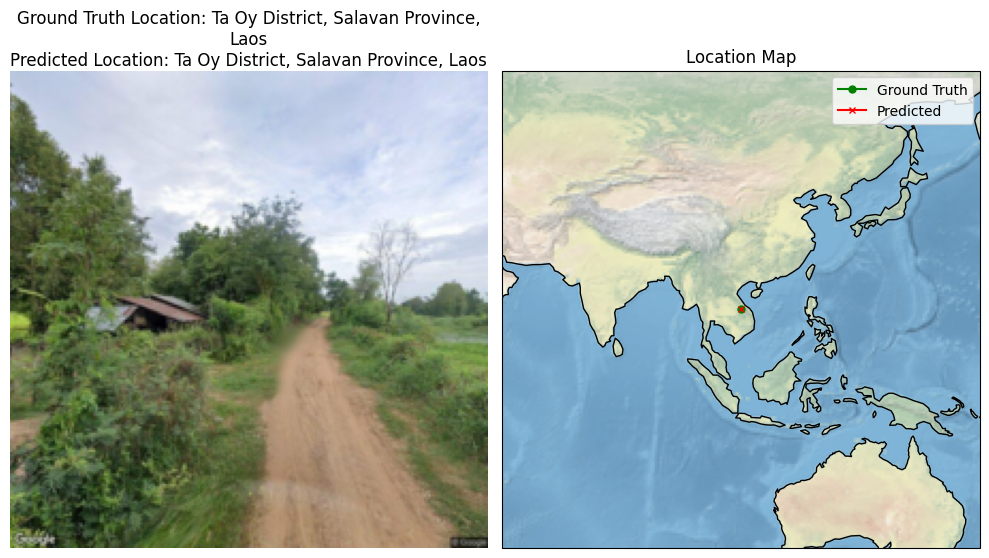

In [ ]:
demo()

<ipython-input-38-d1311f02264a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("GeoScout.pth"))


              precision    recall  f1-score   support

           0       0.83      0.89      0.86        28
           1       0.81      1.00      0.89        21
           2       0.88      0.73      0.80        30
           3       0.93      0.88      0.90        32
           4       1.00      0.93      0.96        29
           5       0.82      0.86      0.84        21
           6       1.00      0.85      0.92        33
           7       0.74      0.82      0.78        28
           8       0.92      0.69      0.79        32
           9       0.84      0.88      0.86        24
          10       0.89      0.97      0.93        34
          11       0.81      1.00      0.90        22
          12       0.96      0.92      0.94        24
          13       0.86      0.96      0.91        25
          14       0.83      0.83      0.83        29
          15       0.82      0.88      0.85        26
          16       0.83      0.91      0.87        22
          17       0.96    

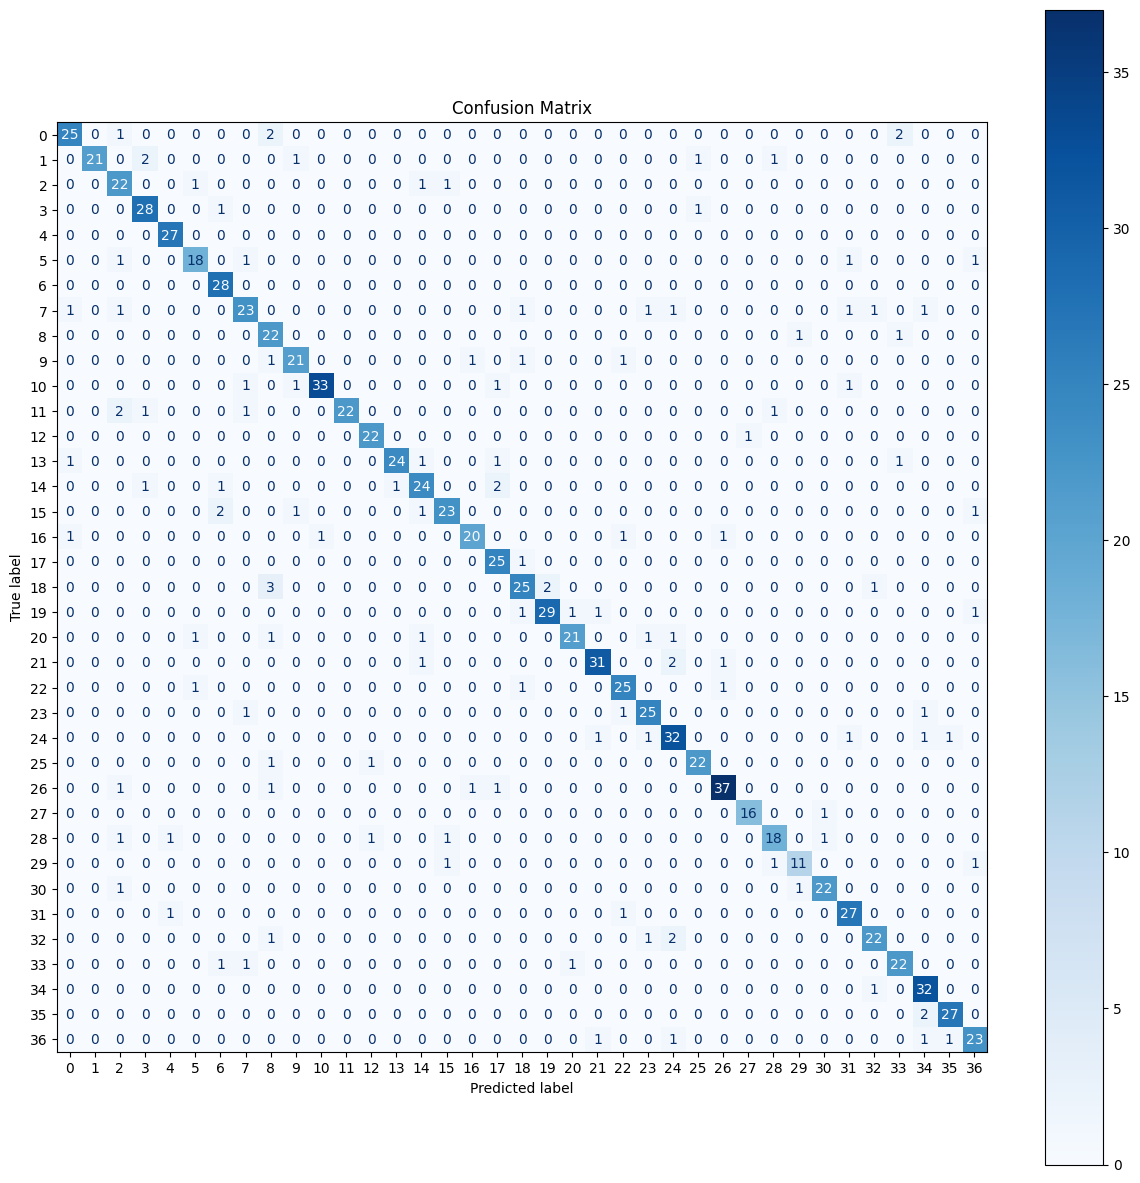

Acc: 0.47349165801838766 | Loss: 0.8746173625566304
Acc: 0.4763182599170535 | Loss: 0.8774509803921569
Acc: 0.4568721781758701 | Loss: 0.8852941176470588


In [ ]:
def temp():
  model = models.resnet18()
  model.fc = torch.nn.Linear(model.fc.in_features, 37)
  model.load_state_dict(torch.load("GeoScout.pth"))
  model.eval()
  if torch.cuda.is_available():
    model = model.cuda()
  else:
    sys.exit(1)

  batch_size = 32
  test_length = 10209
  train_loader, val_loader, test_loader = get_data_loader_2(batch_size, test_length)
  generate_confusion_matrix(model, val_loader)

  acc, loss = validate(model,nn.CrossEntropyLoss(),'cuda',train_loader)
  print(f"Acc: {acc} | Loss: {loss}")
  acc, loss = validate(model,nn.CrossEntropyLoss(),'cuda',val_loader)
  print(f"Acc: {acc} | Loss: {loss}")
  acc, loss = validate(model,nn.CrossEntropyLoss(),'cuda',test_loader)
  print(f"Acc: {acc} | Loss: {loss}")

temp()

In [ ]:
from s2sphere import CellId, LatLng

s2_cell_id = 9925933578724573184

try:
    cell_id = CellId(s2_cell_id)
    if cell_id.is_valid():
        latlng = cell_id.to_lat_lng()
        location = (latlng.lat().degrees, latlng.lng().degrees)
        print(f"Location: {location}")
    else:
        print("Invalid S2 cell ID.")
except Exception as e:
    print(f"Error: {e}")

Location: (38.794595155857685, -73.46516214265485)
